# GIS with Geopandas

As noted in our introductory reading, GIS data comes in two flavors -- vector data and raster data. In this course, we'll be learning about the main Python package for working with vector geospatial data: Geopandas!

Geospatial vector data generally comes to us in the form of a regular tabular dataset where each row constitutes a single observation, and each column constitutes a different variable. Unlike regular tabular data, however, each observation in vector data also contains information relating the observation to a location in the world. 

The term "vector data" comes from the fact that observations are linked to locations in the world by associating each observation with a geometric object -- a point, line, or polygon -- and each of these geometric shapes is represented by a series of vertices (x-y coordinates) connected by straight lines. For example, we can represent this square:

![Unit Square](https://upload.wikimedia.org/wikipedia/commons/7/71/Unit_Square.svg)

with a vector consisting of the x-y coordinates of the corners of the square (the square's *vertices*): `[(0, 0), (1, 0), (1, 1), (0, 1)]` (image source: [Wikipedia](https://en.wikipedia.org/wiki/Unit_square#/media/File:Unit_Square.svg)).

The ability to represent the relationship between units of observation and locations on earth using these geometric shapes is extremely powerful. Not only can we represent the location of singular objects with points (e.g. stores, customers, cellphone towers, etc.), but we can also represent things like roads or rivers with lines, and we can represent areas like countries, media markets, census blocks, etc. with polygons.

Moreover, because these shapes are all represented using collections of coordinates in a two-dimensional plane, these different geometric shapes can interact easily. For example, it's easy to all the customers (represented by points) in one dataset that are physically located inside a media market represented in another dataset by a polygon.



## Wait, Only Two Dimensions?

At this point, some careful readers may be saying to themselves: "Uh... hey: how are we just storing the vertices of these shapes as x-y coordinates? The world isn't flat, so how are we representing everything in two dimensions?"

Great question careful reader! The short answer is that we employ some tricks to *project* locations on the surface of the Earth onto a two-dimensional plane. That's because working in two-dimensions is *much* easier than working in three, and since we're usually interested in just locating things on the *surface* of the Earth, we don't lose too much working in two dimensions. We'll talk a lot more about how this is done (including the nuances of how we project locations onto a two-dimensional plane), but for the moment, it's enough to know that we can.

Indeed, you're almost surely already familiar with one trick we use to do this: latitude and longitude! Every location on the surface of the Earth can be identified by specifying a latitude and longitude, which are (in effect) just x-y coordinates.

So for the moment, if thinking about coordinates in two dimensions feels odd, just think of these coordinates as latitudes and longitudes.

As mentioned in our [last reading](gis_what_is_gis.ipynb), though, and as we'll discuss in detail in a later reading, we definitely aren't limited to latitude and longitude -- indeed, the tools we're using can be used for any representation of locations in two dimensions, like locations in a warehouse or on a football field!

## Geopandas

Because vector spatial data is essentially just regular tabular data + a geometric shape associated with each row, in this course we will be using a library called geopandas that, as the name implies, is based on pandas. In effect, geopandas represents vector spatial data as a pandas DataFrame that includes an object column with a geometric shape for each row (something it calls a GeoDataFrame)! To illustrate, here's the GeoDataFrame of all the countries in the world we saw in the last reading:

In [ ]:
import geopandas as gpd
import geodatasets

# Load GIS data

geodatasets
world = gpd.read_file(
    "https://github.com/nickeubank/practicaldatascience_book/raw/refs"
    "/heads/main/notebooks/gis/example_data/world_countries/world_countries_mercator.geojson"
)

# Look at the data
world.sample(5)

,featurecla,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,tlc,admin,...,fclass_tr,fclass_id,fclass_pl,fclass_gr,fclass_it,fclass_nl,fclass_se,fclass_bd,fclass_ua,geometry
102,Admin-0 country,1,2,Pakistan,PAK,0,2,Sovereign country,1,Pakistan,...,None,None,None,None,None,None,None,None,None,"POLYGON ((77.83745 35.49401, 76.87172 34.65354..."
5,Admin-0 country,1,3,Kazakhstan,KA1,1,1,Sovereignty,1,Kazakhstan,...,None,None,None,None,None,None,None,None,None,"POLYGON ((87.35997 49.21498, 86.59878 48.54918..."
128,Admin-0 country,1,6,Luxembourg,LUX,0,2,Sovereign country,1,Luxembourg,...,None,None,None,None,None,None,None,None,None,"POLYGON ((6.04307 50.12805, 6.24275 49.90223, ..."
130,Admin-0 country,1,5,Netherlands,NL1,1,2,Country,1,Netherlands,...,None,None,None,None,None,None,None,None,None,"POLYGON ((6.90514 53.48216, 7.09205 53.14404, ..."
118,Admin-0 country,1,5,Lithuania,LTU,0,2,Sovereign country,1,Lithuania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((26.49433 55.61511, 26.58828 55.16718..."


<Axes: >

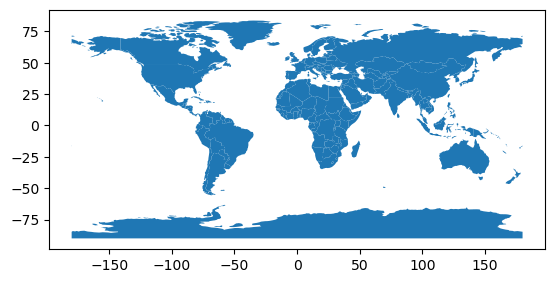

In [2]:
world.plot()

Crucially, this means that GeoDataFrames support all the operations you're familiar with from pandas, including merging, subsetting, etc. In fact, geopandas isn't just based on pandas in an abstract sense -- the way geopandas is written is by "inheriting" the DataFrame class from pandas then adding to it. So as soon as something changes in pandas, those changes will propagate to geopandas as well.

(Honestly, this may be one of the only instances I've ever seen of the inheritance idea from object-oriented programming actually working well).

To illustrate, here is some familiar subsetting syntax:

<Axes: >

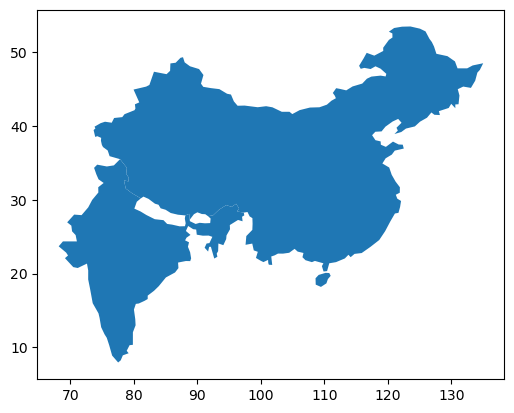

In [3]:
# Get countries whose population is at least 10x the
# average county population
big_countries = world[world["pop_est"] > world["pop_est"].mean() * 10]

# And plot the subsets
big_countries.plot()

China and India! Great. 

Also, note the axes -- as noted above, one example of how we represent spatial data in two dimensions is by making our x-y coordinates equal to latitudes and longitudes, and that's precisely the representation being used here. Indeed, if we try to look at the actual shape object for a single country (say, India, which is located between 70 and 100 degrees Longitude (x-coordinate) and between 10 and 40 degrees of Latitude (y-coordinate)), we can see India is represented by a `POLYGON` object whose vertices all have values in that range, as we'd expect:

In [4]:
world.loc[world.name == "India", "geometry"]

98    POLYGON ((97.32711 28.26158, 97.40256 27.88254...
Name: geometry, dtype: geometry

### Is that it?

While conceptually we can think of geopandas as being like pandas + a column for spatial data, that's not *all* it is. It also includes the following features we'll explore below:

- **Reading and Writing Spatial Data:** Spatial data has a number of standard data formats (shapefiles, geojson, etc.), and geopandas provides tools for reading and writing to all these formats (yay!).
- **Measuring Spatial Relationships:** Geopandas is deeply integrated with libraries for geometric manipulations, making it easy to do things like measure the distances between points in your data (say, to see if your sales people are spread out efficiently). And as mentioned before, one great use of GIS is to join records from different databases based on locality -- say, pulling the records of all census blocks within a mile of a potential new store location to measure your potential customers' average incomes.
- **Projection Management:** GeoDataFrames include an attribute (the Coordinate Reference System, or CRS) that keeps track of the projection used to convert locations on the Earth into the x-y coordinates in our geometric shapes (the vertices themselves are just stored as floating point numbers). In the case of the `world` GeoDataFrame we saw above, for example, the GeoDataFrame's CRS says "hey, the x-y coordinates used here are latitude and longitudes". So your GeoDataFrame stores this information, and provides some tools for converting projections as well. 
- **Mapping:** As you've already seen, geopandas makes maps easy to generate.
- **Tools for Geometric Manipulations:** The utility of these tools are a little tricky to explain at this point, but geopandas has tools for doing things like taking points and expanding them into circles of a given diameter, or intersecting polygons.

So while geopandas is great in that it should feel very familiar, don't be fooled into thinking it doesn't also have a lot of extra skills to offer!

(Note: all these abilities are rooted in other libraries that geopandas integrates into a single tool, so if you start reading about GIS in Python, you're likely to come across references to libraries like Shapely, PyGEOS, fiona, pyproj, etc. Those aren't really "alternatives", but rather libraries that can be used independently, but which are integrated into geopandas.)


## One (Geometry) Column To Rule Them All

One key geopandas concept is that unlike normal DataFrames -- where all columns are created equal -- a GeoDataFrame always has one (and only one) "official geometry" column. This "official geometry" column is the column that contains the geometric objects that are used when doing spatial operations.

By default, this column is named `geometry`, but that need not be the case -- the column that is the active "official geometry" is the one whose name is stored in `gdf.geometry.name`. So for our world dataset, that column is currently the column named `geometry`:

In [5]:
world.geometry.name

'geometry'

But there are situations where you may want to change the "official geometry." Suppose we wanted to create a new column in our dataset that contained the centroid of each country (basically point in the "middle" of each country). We would start by using `.centroid` to create a new column containing `POINT` objects -- one per country -- containing each country's centroid (we'll talk more about these kinds of geometric manipulations later, don't worry!):

In [6]:
world["country_centroids"] = world.centroid
world.sample(3)

/var/folders/fs/h_8_rwsn5hvg9mhp0txgc_s9v6191b/T/ipykernel_60348/1055431317.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world["country_centroids"] = world.centroid


,featurecla,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,tlc,admin,...,fclass_id,fclass_pl,fclass_gr,fclass_it,fclass_nl,fclass_se,fclass_bd,fclass_ua,geometry,country_centroids
77,Admin-0 country,1,5,Lebanon,LBN,0,2,Sovereign country,1,Lebanon,...,None,None,None,None,None,None,None,None,"POLYGON ((35.8211 33.27743, 35.5528 33.26427, ...",POINT (35.87099 33.91183)
55,Admin-0 country,1,3,Niger,NER,0,2,Sovereign country,1,Niger,...,None,None,None,None,None,None,None,None,"POLYGON ((14.8513 22.86295, 15.09689 21.30852,...",POINT (9.32443 17.34555)
99,Admin-0 country,1,3,Bangladesh,BGD,0,2,Sovereign country,1,Bangladesh,...,None,None,None,None,None,None,None,None,"POLYGON ((92.67272 22.04124, 92.65226 21.32405...",POINT (90.26793 23.83946)


(The error telling us we shouldn't be calculating distances using a "geographic CRS" is important, and I'd never ignore it if we were doing a serious analysis. Explaining it requires explaining projections, however, which I'd like to put off till a [later reading](gis_projections_and_crs.ipynb). Duke students: this is on the schedule for our next class. Non-Duke students: if you're just coming to this through google, *please* be sure to read that other reading too!)

We can see we now have two columns with geometric objects in them: `geometry` and `country_centroids`. But if I try and do a spatial operation -- e.g. making a map -- we'll see the GeoDataFrame still gives primacy to the `geometry` column:

<Axes: >

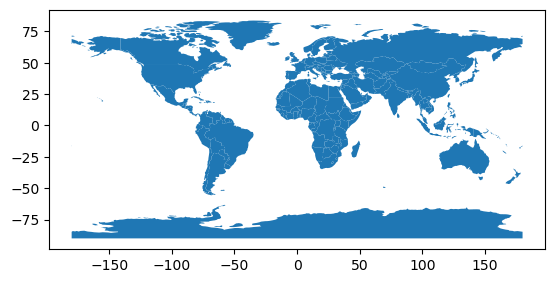

In [7]:
world.plot()

But if I *change* the "official geometry" column with `world.set_geometry("country_centroids")` and then plot the data again, we now see its plotting the centroids:

<Axes: >

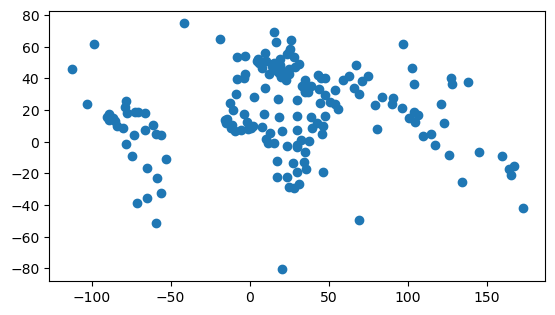

In [8]:
world = world.set_geometry("country_centroids")
world.plot()

**Is it confusing that `world` still has a column called "geometry" that isn't the "official geometry" column?** Yes. Yes it is. Which is why I keep using the term "official geometry" in quotes to refer to the column being given primacy for spatial operations. But that's just something *I'm* doing here -- geopandas just allows for having two things with the same name (here, a column named "geometry" holding the country polygons and the attribute that dictates which column is the "official geometry" column).

And that also means that in geopandas, if you access the `.geometry` attribute, you will always get the "official geometry" column, **not** the column *named* geometry if they are different:


In [9]:
world.geometry

0      POINT (163.85316 -17.31631)
1        POINT (34.75299 -6.25773)
2       POINT (-12.13783 24.29117)
3       POINT (-98.14238 61.46908)
4      POINT (-112.59944 45.70563)
                  ...             
172      POINT (20.81965 44.23304)
173      POINT (19.28618 42.78904)
174      POINT (20.89536 42.57937)
175     POINT (-61.33037 10.42824)
176       POINT (30.19862 7.29289)
Name: country_centroids, Length: 177, dtype: geometry

Yeah... I'm sure in retrospect that they wish they'd used a special name for that attribute, but this is sometimes how software works -- you made a decision, and now it's an integral part of so many people's code, you can't change it without breaking everyone's work. So... that's just a thing you have to deal with!

## What's Next

There's much more to come! Next up, [let's read about merging spatial data!](gis_spatial_joins.ipynb)